# SimMobility visualization - Travel time and distance by residential area

Author: Lukas Ralf Schinzel, Master student at Technical University of Denmark (DTU)

**1. Information on Kepler GL Kupyter**

Documentation and installation of Kepler GL for Jupyter: https://docs.kepler.gl/docs/keplergl-jupyter  
User guide Kepler GL: https://docs.kepler.gl/docs/user-guides  
It is recommended to use Kepler GL for Jupyter in a Jupyter Notebook, not in Jupyter Lab.

**2. Visualization concept**

This visualization aims to provide insights into how travel times and distance changes for the simulated population when changing from one SimMobility scenario to another. In order to find out how travel time develops for different residential areas (i.e. how average travel time and distance for individuals living in a specific zone changes), a choropleth is created. It shows changes in travel time according to place of residence in the city. Colors encode the average daily travel time for the individuals living in a specific zone. In this way, it can for example be identified whether more remote parts of the city are disadvantaged by a decision or whether their accessibility is increased.  
The map visualization is complemented by bar charts in order to provide insights into changes for certain demographic groups. In this way, it can for example be discovered, whether low income groups are disadvantaged when changing from one scenario to the other.

The only input required by the user is to specify the input parameters in section 6. Other than that, it is only expected to rerun the notebook for each new visualization or when input parameters are changed.

The default configuration for the visualization in Kepler GL is saved in a Python script, which is automatically loaded from a configuration file when the visualization is created. The visualization can be adjusted using Kepler GL’s user interface.

**3. Required data**
- subtrip metrics
- population (individual.csv)
- households
- zones
- income categories
- education categories
- employment status categories

**4. Libraries**

In [1]:
# import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
from keplergl import KeplerGl

**5. Functions**

In [2]:
def load_subtrip_metrics(filepath:str, has_headers=False):
    
    '''Loads subtrip metrics from CSV into pandas data frame.'''
    
    # relevant_cols = ['person_id', 'trip_id', 'subtrip_id', 'mode', 'start_time', 'end_time', 'travel_time', 'total_dist']

    # define headers
    headers_sm = ['person_id', 'trip_id', 'subtrip_id', 'origin_type', 'origin_node', 'origin_taz', 'destination_type', 'destination_node',
                  'destination_taz', 'mode', 'start_time', 'end_time', 'travel_time', 'total_distance', 'cbd_entry_node', 'cbd_exit_node', 'cbd_entry_time',
                  'cbd_exit_time', 'cbd_travel_time', 'non_cbd_travel_time', 'cbd_distance', 'non_cbd_distance']

    # define date types
    dtypes_sm = {'person_id': 'str', 'trip_id': 'str', 'subtrip_id': 'str', 'origin_type': 'str', 'origin_node': 'str', 'origin_taz': 'str', 'destination_type': 'str',
                 'destination_node': 'str', 'destination_taz': 'str', 'mode': 'str', 'start_time': 'str', 'end_time': 'str', 'travel_time': 'float', 'total_distance': 'float',
                 'cbd_entry_node': 'str', 'cbd_exit_node': 'str', 'cbd_entry_time': 'str', 'cbd_exit_time': 'str', 'cbd_travel_time': 'float', 'non_cbd_travel_time': 'float',
                 'cbd_distance': 'float', 'non_cbd_distance': 'float'}

    # define datetime columns
    datetime_cols_sm = ['start_time', 'end_time', 'cbd_entry_time', 'cbd_exit_time']

    # load subtrip metrics
    if not has_headers:
        df_sm = pd.read_csv(filepath, names=headers_sm, index_col=False, dtype=dtypes_sm, parse_dates=datetime_cols_sm)
    elif has_headers:
        df_sm = pd.read_csv(filepath, index_col=False, dtype=dtypes_sm, parse_dates=datetime_cols_sm)
    else:
        raise Exception("Please specify has_headers as either True or False.")
        
    # manipulation person IDs to fit format in population data
    df_sm['person_id'] = df_sm['person_id'].str.split('-', expand=True)[0] # remove digits after the dash
    df_sm['person_id'] = df_sm['person_id'].str[0:9] # reduce to 9 figure number (MIGHT NEED TO BE CHANGED DEPENDING ON POPULATION DATA)
        
    return df_sm

In [3]:
def load_population(filepath:str, df_household):
    
    '''Loads population data from CSV (individual.csv) and adds home zone from household data.'''
    
    df_population = pd.read_csv(filepath)
    df_population = df_population.rename(columns={'id': 'person_id'})
    df_population['person_id'] = df_population['person_id'].astype('str')
    df_population = df_population.set_index('person_id')
    df_population = df_population.join(other=df_household.set_index('id')['taz_id'], on='hhid')

    return df_population

In [4]:
def get_travel_info(df_subtrip_metrics):
    
    '''Generates total travel time and total travel distance for population from subtrip metrics.'''
    
    df_subtrip_metrics = df_subtrip_metrics[['person_id', 'travel_time', 'total_dist']]
    df_travel_info = df_subtrip_metrics.groupby('person_id').sum()
    
    return df_travel_info

In [5]:
def get_travel_changes(df_sm_A, df_sm_B, df_population):
    
    '''Combines travel info from two scenarios A and B and calculates changes in
    travel time and distance for the population.'''
    
    # generate travel info
    df_travel_info_A = get_travel_info(df_sm_A)
    df_travel_info_B = get_travel_info(df_sm_B)

    # combine them
    df_travel_info = df_travel_info_A.join(other=df_travel_info_B, on='person_id', lsuffix='_A', rsuffix='_B')
    
    # rename columns
    df_travel_info = df_travel_info.rename(columns={'travel_time_A':'travel_time_A_[h]',
                                                    'travel_time_B':'travel_time_B_[h]',
                                                    'total_dist_A': 'total_dist_A_[m]',
                                                    'total_dist_B': 'total_dist_B_[m]'})

    # calculate differences
    df_travel_info['delta_travel_time_[h]'] = df_travel_info['travel_time_B_[h]'] - df_travel_info['travel_time_A_[h]']
    df_travel_info['delta_total_dist_[m]'] = df_travel_info['total_dist_B_[m]'] - df_travel_info['total_dist_A_[m]']

    # join on population data
    df_population_travel = df_population.join(other=df_travel_info, on='person_id', how='inner')
    
    return df_population_travel

In [6]:
def plot_delta_travel_time_and_distance_by_demographics(df_population_travel, group_by):
    
    '''Groups travel data by demographic group and plots respective travel times and distances
    in a horizontal bar chart.'''
    
    if group_by == 'income':
        grouping_arg = 'income'
        categories = income_categories['name']
    elif group_by == 'education':
        grouping_arg = 'education_type_id'
        categories = education_categories['name']
    elif group_by == 'employment_status':
        grouping_arg = 'person_type_id'
        categories = employment_categories['name']
    else:
        raise Exception("Please specify 'group_by' argument as either 'income', 'education' or 'employment_status'.")
        
    # group by income group
    df = df_population_travel.groupby(grouping_arg).sum()
    
    # calculate percentage changes in travel time and distance
    df['delta_travel_time_percentage'] = (df['travel_time_B_[h]'] - df['travel_time_A_[h]'])*100 / df['travel_time_A_[h]']
    df['delta_total_dist_percentage'] = (df['total_dist_B_[m]'] - df['total_dist_A_[m]'])*100 / df['total_dist_A_[m]']
        
    # create figure
    print('\n Changes by {}:'.format(group_by.replace('_',' ')))
    fig, ax = plt.subplots(1,2, figsize=(13.5,len(df)/2), sharey=False, constrained_layout=True)
    if group_by == 'income':
        xlabels = categories[df.index] + ' ' + income_categories['currency'][df.index].str.upper()
    else:
        xlabels = categories[df.index]
        
    # create travel time plot by income group
    ax[0].barh(xlabels, df.delta_travel_time_percentage, color=(0.77, 0.0, 0.05))
    ax[0].xaxis.set_major_formatter(mtick.PercentFormatter())
    ax[0].set_xlabel('Δ travel time')
    ax[0].set_title('Changes in overall daily travel time [h] by {}'.format(group_by.replace('_',' ')), fontsize=12)
    
    # create travel distance plot by income group
    ax[1].barh(xlabels, df.delta_total_dist_percentage, color=(0, 0, 0.4))
    ax[1].xaxis.set_major_formatter(mtick.PercentFormatter())
    ax[1].set_xlabel('Δ travel distance')
    ax[1].set_title('Changes in overall daily travel distance [m] by {}'.format(group_by.replace('_',' ')), fontsize=12)
    
    plt.show()

In [7]:
def load_zones(filepath:str, epsg):
    
    '''Loads zones from shapefile (zone_filename.shp) into geopandas data frame.'''
    
    zones = gpd.read_file(filepath)
    zones = zones.set_crs(epsg=str(epsg))
    zones = zones.to_crs(epsg='4326') # necessary if correct CRS is set above?
    
    return zones

In [14]:
def get_travel_changes_per_zone(df_population_travel_info):
    
    '''Aggregates population travel information (df_population_travel_info) to zones.'''
    
    # group by zones
    df_zones_travel_info = df_population_travel_info.groupby('taz_id').mean()

    # add percentage changes
    df_zones_travel_info['delta_travel_time_[%]'] = df_zones_travel_info['delta_travel_time_[h]'] / \
                                                    df_zones_travel_info['travel_time_A_[h]']
    df_zones_travel_info['delta_total_dist_[%]'] = df_zones_travel_info['delta_total_dist_[m]'] / \
                                                   df_zones_travel_info['total_dist_A_[m]']

    # replace infinite values with NaN (from: https://stackoverflow.com/questions/17477979/dropping-infinite-values-from-dataframes-in-pandas)
    df_zones_travel_info.replace([np.inf, -np.inf], np.nan, inplace=True)

    # add zone polygons
    df_zones_travel_info_2 = df_zones_travel_info.join(other=zones.set_index('TAZ')['geometry'], on='taz_id')

    # convert to geopandas data frame
    df_zones_travel_info_2 = gpd.GeoDataFrame(df_zones_travel_info_2, geometry='geometry')
    
    return df_zones_travel_info_2

**6. Create visualization**

Specify filepaths for data: 

In [8]:
# subtrip metrics for scenario A and B
filepath_sm_A = '../Data/Boston/DTU/Boston_Lukas/subtrip_metrics_full_run_prototype.csv'
filepath_sm_B = '../Data/Boston/DTU/Boston_Lukas/subtrip_metrics_feddback.csv'

# population
filepath_population = '../Data/Boston/DTU/Boston_Lukas/individual_by_id_for_preday_new.csv'

# households
filepath_households = '../Data/Boston/DTU/Boston_Lukas/household_cr.csv'

# zones
filepath_zones = '../Data/Boston/DTU/Boston_Lukas/zone shapefiles/CTPS_TOWN_TAZ_2012_POLYM.shp'

# income categories
filepath_income_categories = '../Data/Boston/DTU/Boston_Lukas/income_category.csv' # this might be from Singapore!

# education categories
filepath_education_categories = '../Data/Boston/DTU/Boston_Lukas/education.csv'

# employment status categories
filepath_employment_categories = '../Data/Boston/DTU/Boston_Lukas/employment_status.csv'

Specify data format: Do subtrip metrics files contain headers?

In [9]:
sm_A_has_headers = True
sm_B_has_headers = True

Specify EPSG in which zones are stored:

In [10]:
epsg = '26986'

**7. Create visualization:**

In [11]:
# load population data
df_household = pd.read_csv(filepath_households)
df_population = load_population(filepath_population, df_household)

income_categories = pd.read_csv(filepath_income_categories, index_col='id')
education_categories = pd.read_csv(filepath_education_categories, index_col='id')
employment_categories = pd.read_csv(filepath_employment_categories, index_col='id')

In [12]:
# load geographic data
zones = load_zones(filepath_zones,epsg=epsg)

In [13]:
# load subtrip metrics
df_sm_A = load_subtrip_metrics(filepath_sm_A, has_headers=sm_A_has_headers)
df_sm_B = load_subtrip_metrics(filepath_sm_B, has_headers=sm_B_has_headers)

In [24]:
# get travel info for population
df_population_travel_info = get_travel_changes(df_sm_A, df_sm_B, df_population)  

# aggregate travel info to zones (by this, no filtering by demographics possible in Kepler GL)
df_zones_travel_info_2 = get_travel_changes_per_zone(df_population_travel_info)

In [25]:
# load the map configuration saved
%run travel_time_config.py # --> stores configuration in variable 'config'

In [ ]:
# load the map
map_travel_info = KeplerGl(height=600,
                           data={'travel_info': df_zones_travel_info_2},
                           config=config,
                          )
map_travel_info

(Note: Regenerating the map requires to regenerate the input data frame.)


 Changes by income:


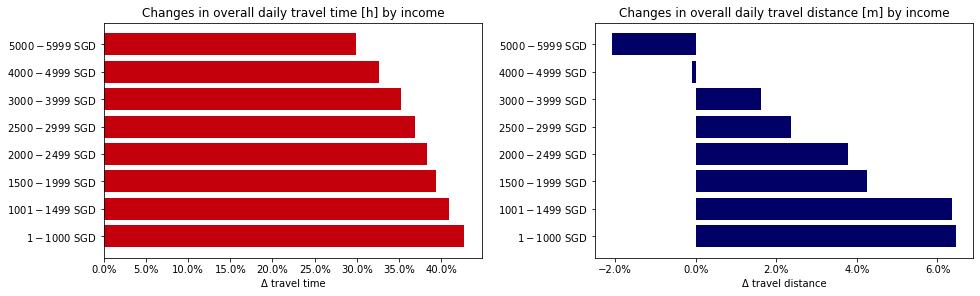


 Changes by education:


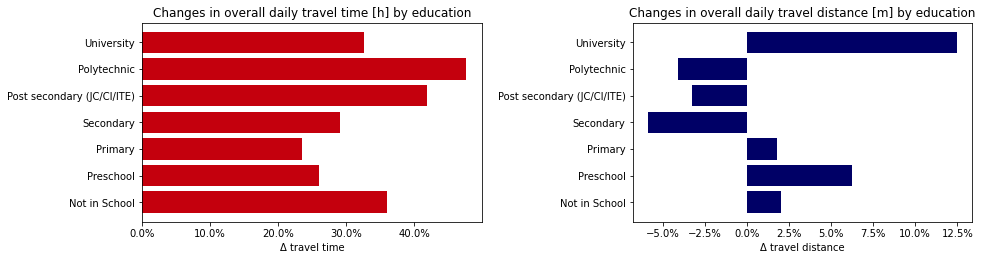


 Changes by employment status:


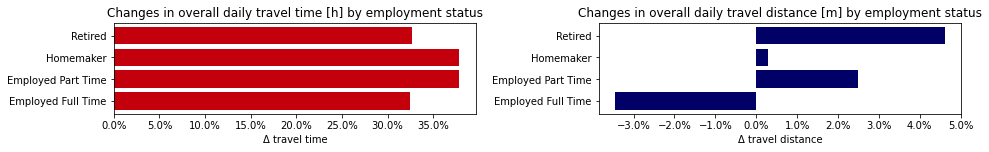

In [19]:
# plot additional informative graphs
plot_delta_travel_time_and_distance_by_demographics(df_population_travel_info, group_by = 'income')
plot_delta_travel_time_and_distance_by_demographics(df_population_travel_info, group_by = 'education')
plot_delta_travel_time_and_distance_by_demographics(df_population_travel_info, group_by = 'employment_status')

**8. Optional**

Saving new map configuration (optional):  
(mind that current configuration files will be overwritten if stored with same filename in same folder!)